In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Used for ploting
import seaborn as sns #used for Visualiztion

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer  #could have used tf-idf feature extractor
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [3]:

TRM=pd.read_csv('matches.csv')
TRM.index=TRM['id']
TRD=pd.read_csv('deliveries.csv')

In [4]:
TRM.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
id,,,,,,,,,,,,,,,,,,
1,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
2,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
3,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
4,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
5,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Intially we plot a histogram to find number of matches that each team won in IPL and also find which teams stood out.

In [5]:
import os
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls

In [6]:
matches_played_byteams=pd.concat([TRM['team1'],TRM['team2']])
matches_played_byteams=matches_played_byteams.value_counts().reset_index()
matches_played_byteams.columns=['Team','Total Matches']
matches_played_byteams['wins']=TRM['winner'].value_counts().reset_index()['winner']
matches_played_byteams.set_index('Team',inplace=True)

trace1 = go.Bar(
    x=matches_played_byteams.index,
    y=matches_played_byteams['Total Matches'],
    name='Total Matches'
)
trace2 = go.Bar(
    x=matches_played_byteams.index,
    y=matches_played_byteams['wins'],
    name='Matches Won'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

This graph shows that total matches that each team played and the number of matches they won.

### DROPPING THE NULL VALUES

Checking up the null values and damaged data values in the dataset and removing them will give the correct ouput .

Now create the feature table to train our data and create the table . All the matches are identified by the match_id so we can make this field as the primary_index of the feature table and we have to find that total matches played . From the given dataset we can infer that match_id lies from 1 to 500 matches. Now setting up the team details like which teams are going to play in the match on the respective id's.So add Team A and Team B columns to the FT Dataframe

In [7]:
# Creating Feature Table
FT=pd.DataFrame()

# Making match_id as the index
FT["match_id"]=TRM["id"]
FT.index=FT["match_id"]

print('Total Matches Played:',TRM.shape[0])

Total Matches Played: 636


Now setting up the team details like which teams are going to play in the match on the respective id's.So add Team A and Team B columns to the FT Datafram

In [8]:
# Adding Team Deatils
FT["Team A"]=TRM["team1"]
FT["Team B"]=TRM["team2"]
FT = FT.drop('match_id', 1)
print('Teams:',FT['Team A'].unique())

Teams: ['Sunrisers Hyderabad' 'Mumbai Indians' 'Gujarat Lions'
 'Rising Pune Supergiant' 'Royal Challengers Bangalore'
 'Kolkata Knight Riders' 'Delhi Daredevils' 'Kings XI Punjab'
 'Chennai Super Kings' 'Rajasthan Royals' 'Deccan Chargers'
 'Kochi Tuskers Kerala' 'Pune Warriors' 'Rising Pune Supergiants']


SEASON FEATURE

TIme is a important feature for prediciting match outcome.Since the time period reputates the growth and their downfalls statistically.In this dataset season feature act as the time period of every match.Now we justify why we taken season as our feature.We also need winning_team result to explorate their winning structure.

<Figure size 576x288 with 0 Axes>

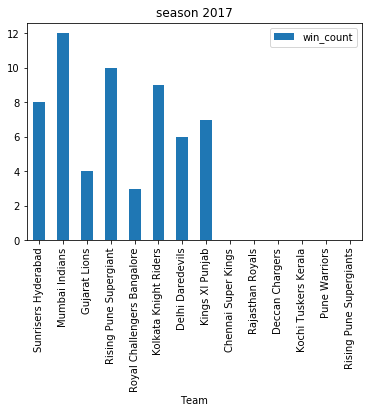

<Figure size 576x288 with 0 Axes>

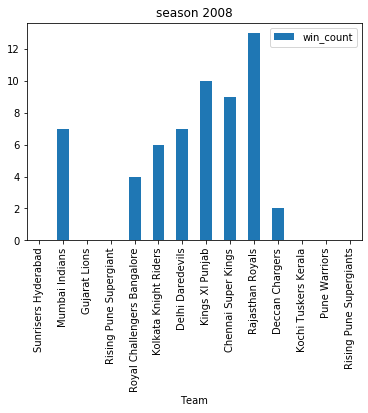

<Figure size 576x288 with 0 Axes>

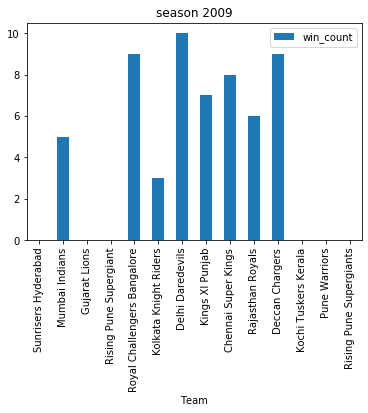

<Figure size 576x288 with 0 Axes>

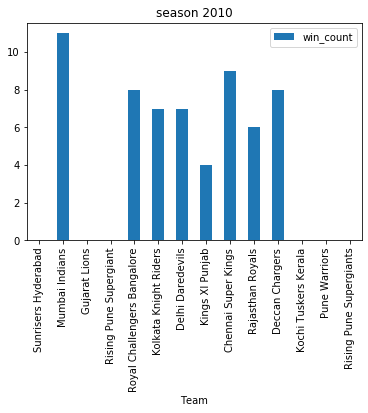

<Figure size 576x288 with 0 Axes>

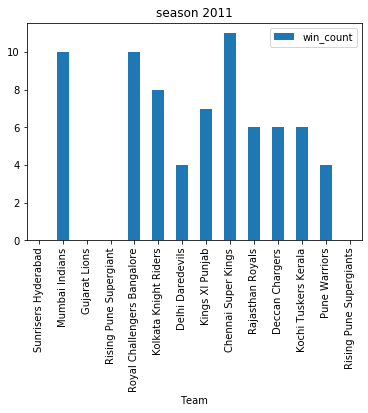

<Figure size 576x288 with 0 Axes>

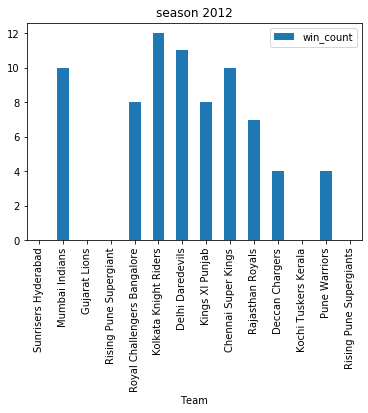

<Figure size 576x288 with 0 Axes>

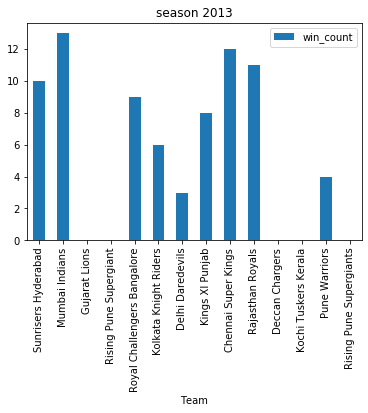

<Figure size 576x288 with 0 Axes>

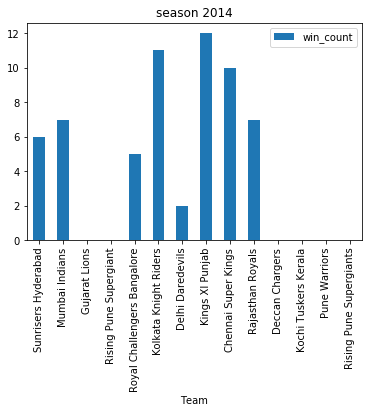

<Figure size 576x288 with 0 Axes>

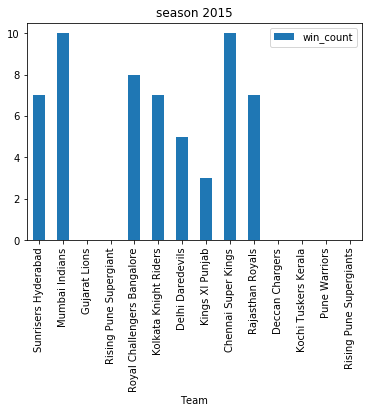

<Figure size 576x288 with 0 Axes>

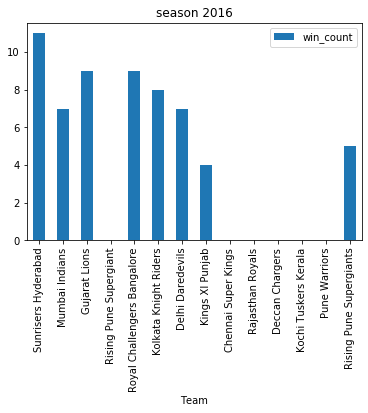

In [9]:
# winning structure.

# Adding season and winner to the feature table
FT["season"]=TRM["season"]
FT["winner"]=TRM["winner"]

#creating the season and team list
season_list=FT['season'].unique()
team_list=FT['Team A'].unique()

#Now check the frequency of each team won during every season

temp_data=pd.DataFrame() # Creating a temporary dataframe    
temp_data["Team"]=team_list
temp_data.index=temp_data["Team"]

for s in season_list:
    winner_season=FT.loc[FT['season']== s,"winner"] # get the series of winners at the particular season
    t=winner_season.value_counts() # count the value of winning_count of each team
    t=t.to_frame() # Series is not efficient to work converting to a dataframe
    temp_data["win_count"]=t["winner"] 
    temp_data['win_count']=temp_data['win_count'].fillna(0)
    temp_data['win_count']=temp_data['win_count'].astype(int)
    tit="season "+str(s)
    fig = plt.figure(figsize=(8,4))
    temp_data.plot(kind='bar',title=tit)

Hence from the above bar plots we can infer that the team_performance varies seasonally.So we concluded the seasonal values as an important feature to the feature table.

winner is our label we dont wanna add this feature by now we can add it later

In [10]:
FT = FT.drop('winner', 1)

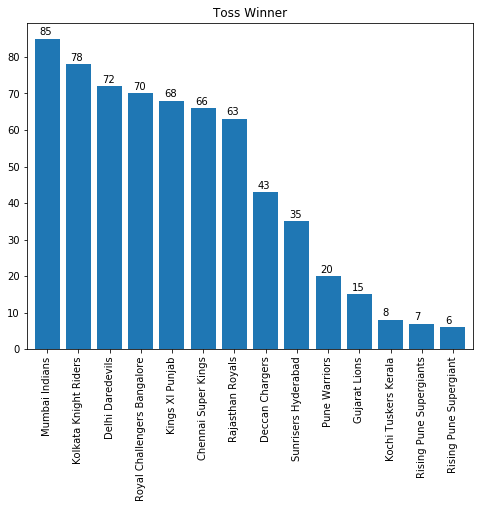

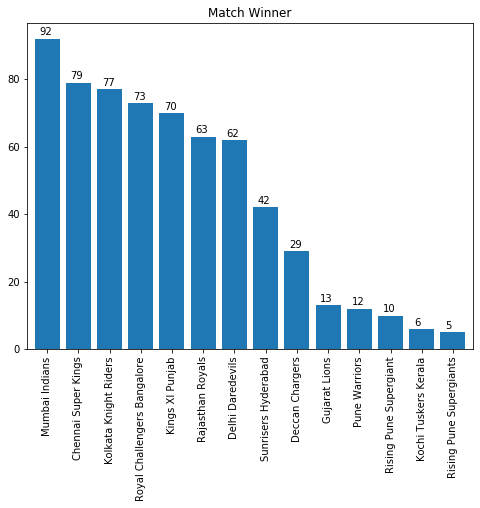

In [12]:
teams=['Team1','Team2','Team3','Team4','Team5','Team6','Team7','Team8','Team9','Team10','Team11']
t=pd.Series(teams)
# finding the frequency of toss winners and the match winners to correlate
temp_toss_winner=pd.DataFrame()
temp_toss_winner['Team']=t.values
temp_match_winner=pd.DataFrame()
temp_match_winner['Team']=t.values

#Caluclating toss_winning and match winning frequency of each team
temp_toss_winner['Count'] = temp_toss_winner['Team'].map(TRM['toss_winner'].value_counts())
temp_match_winner['Count']=temp_match_winner['Team'].map(TRM['winner'].value_counts())

plt.subplots(figsize=(8,6))
ax=TRM['toss_winner'].value_counts().plot.bar(width=0.8)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title("Toss Winner")
plt.show()

plt.subplots(figsize=(8,6))
ax=TRM['winner'].value_counts().plot.bar(width=0.8)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title("Match Winner")
plt.show()

#### We have to know whether toss won act as a important role in winning decision.To check we have to visulaize a probablitic calculation

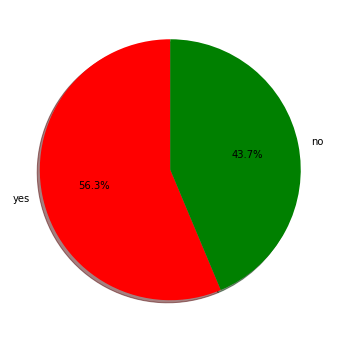

In [13]:
df=TRM[TRM['toss_winner']==TRM['winner']]
slices=[len(df),(577-len(df))]
labels=['yes','no']
plt.pie(slices,labels=labels,startangle=90,shadow=True,explode=(0,0),autopct='%1.1f%%',colors=['r','g'])
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

From this correaltion graph we can identify that toss winning also act as a major feature in predicting the result .From the graph we can infer that 43.7% toss winners are match winners.

In [14]:
# Adding the toss_winner to the feature table
FT["toss_winner"]=TRM["toss_winner"]

#### DUCKWORTH-LEWIS METHOD

Duckworth-Lewis method(D/L method) is a mathematical function defined to set and calculate the target score for the team batting second in One day international cricket matches. It is the most complex and irritating function for the audience who are watching cricket. When duck-worth lewis method is appiled it may errupt the entire prediction system so we should as a feature table to avoid this type of scenarios

In [15]:
dl=TRM.loc[TRM['dl_applied'] == 1]
dl

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
id,,,,,,,,,,,,,,,,,,
57,57,2017,Bangalore,2017-05-17,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,1,Kolkata Knight Riders,0,7,NM Coulter-Nile,M Chinnaswamy Stadium,AK Chaudhary,Nitin Menon,NaN
100,100,2008,Delhi,2008-05-17,Delhi Daredevils,Kings XI Punjab,Delhi Daredevils,bat,normal,1,Kings XI Punjab,6,0,DPMD Jayawardene,Feroz Shah Kotla,AV Jayaprakash,RE Koertzen,NaN
103,103,2008,Kolkata,2008-05-18,Kolkata Knight Riders,Chennai Super Kings,Kolkata Knight Riders,bat,normal,1,Chennai Super Kings,3,0,M Ntini,Eden Gardens,Asad Rauf,K Hariharan,NaN
120,120,2009,Cape Town,2009-04-19,Kings XI Punjab,Delhi Daredevils,Delhi Daredevils,field,normal,1,Delhi Daredevils,0,10,DL Vettori,Newlands,MR Benson,SD Ranade,NaN
123,123,2009,Durban,2009-04-21,Kings XI Punjab,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,1,Kolkata Knight Riders,11,0,CH Gayle,Kingsmead,DJ Harper,SD Ranade,NaN
149,149,2009,Centurion,2009-05-07,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,1,Chennai Super Kings,12,0,ML Hayden,SuperSport Park,DJ Harper,TH Wijewardene,NaN
252,252,2011,Kochi,2011-04-18,Chennai Super Kings,Kochi Tuskers Kerala,Kochi Tuskers Kerala,field,normal,1,Kochi Tuskers Kerala,0,7,BB McCullum,Nehru Stadium,K Hariharan,AL Hill,NaN
281,281,2011,Kolkata,2011-05-07,Chennai Super Kings,Kolkata Knight Riders,Chennai Super Kings,bat,normal,1,Kolkata Knight Riders,10,0,Iqbal Abdulla,Eden Gardens,Asad Rauf,PR Reiffel,NaN
291,291,2011,Bangalore,2011-05-14,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,1,Royal Challengers Bangalore,0,4,CH Gayle,M Chinnaswamy Stadium,RE Koertzen,RB Tiffin,NaN


Totally 10 matches is influenced by dl method the only go is to remove these 10 matches or add this as a feature to the feature table.But I select to add this as feature beacause our model will be trained to predict the   
#### dl applied mathches .

In [16]:
FT["dl_applied"]=TRM["dl_applied"]
FT

,Team A,Team B,season,toss_winner,dl_applied
match_id,,,,,
1,Sunrisers Hyderabad,Royal Challengers Bangalore,2017,Royal Challengers Bangalore,0
2,Mumbai Indians,Rising Pune Supergiant,2017,Rising Pune Supergiant,0
3,Gujarat Lions,Kolkata Knight Riders,2017,Kolkata Knight Riders,0
4,Rising Pune Supergiant,Kings XI Punjab,2017,Kings XI Punjab,0
5,Royal Challengers Bangalore,Delhi Daredevils,2017,Royal Challengers Bangalore,0
...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,2016,Royal Challengers Bangalore,0
633,Gujarat Lions,Royal Challengers Bangalore,2016,Royal Challengers Bangalore,0
634,Sunrisers Hyderabad,Kolkata Knight Riders,2016,Kolkata Knight Riders,0


#### VENUE FEATURE

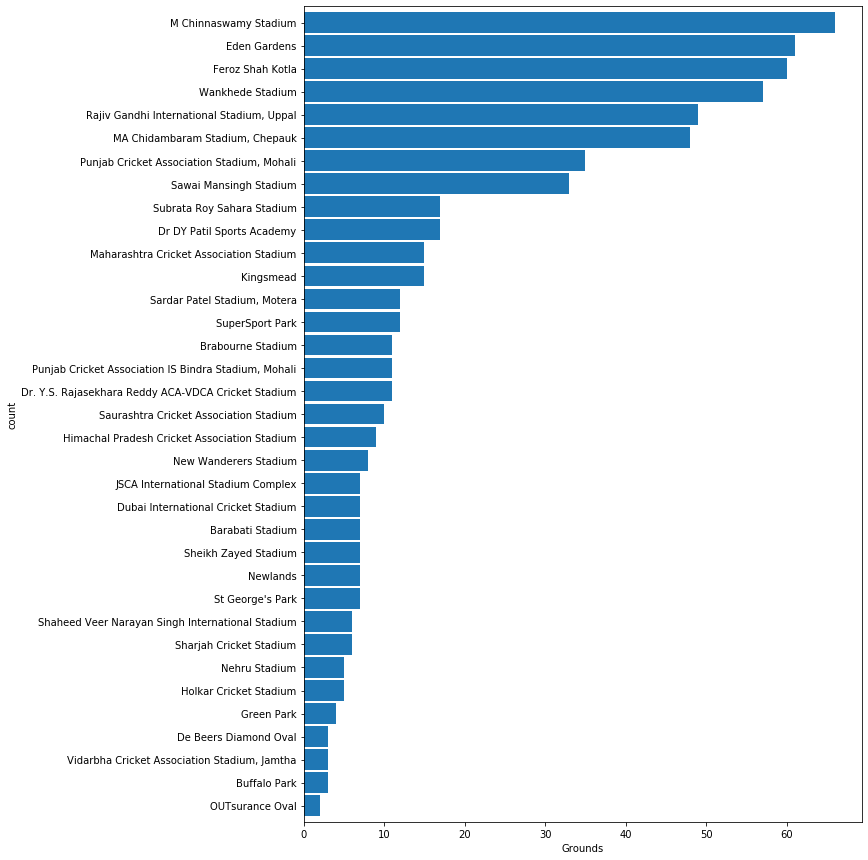

In [17]:
plt.subplots(figsize=(10,15))
ax = TRM['venue'].value_counts().sort_values(ascending=True).plot.barh(width=.9)
ax.set_xlabel('Grounds')
ax.set_ylabel('count')
plt.show()

From this visualization we can infer that most matches are conducted only on major 7 statdiums .From this we can draw to a conclusion that stadium does not play a major role in deciding the victory compare to other features

#### TEAM DELIVERIES

#### RUNS PER OVER ACROSS SEASON

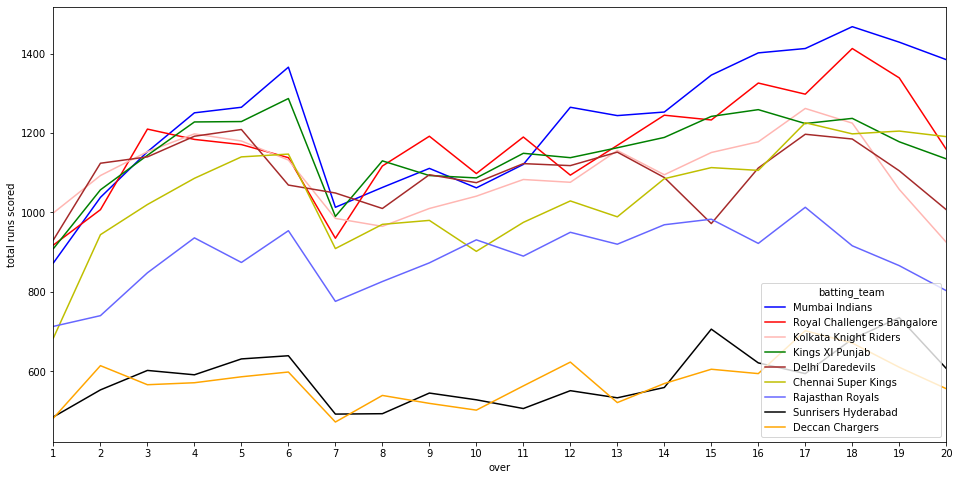

In [18]:
runs_per_over = TRD.pivot_table(index=['over'],columns='batting_team',values='total_runs',aggfunc=sum)
runs_per_over[(matches_played_byteams[matches_played_byteams['Total Matches']>50].index)].plot(color=["b", "r", "#Ffb6b2", "g",'brown','y','#6666ff','black','#FFA500']) #plotting graphs for teams that have played more than 100 matches
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.xticks(x)
plt.ylabel('total runs scored')
fig=plt.gcf()
fig.set_size_inches(16,8)
plt.show()

rom this visualization we can say that we have to calculate the batting and bowling average of each team to calcuate the overall performance.

In [39]:
def Batting_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_bruns=over_temp_frame['bye_runs'].sum()
        total_lbruns=over_temp_frame['legbye_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['batsman_runs'] != 0,"batsman_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['batsman_runs']==0,"batsman_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(1*total_bruns+1*total_lbruns+2*b_non_zero-1*b_dot+-3*b_dis)/5
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bat_av=over_average["average"].mean()
    return bat_av

In [40]:

def Bowling_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_wr=over_temp_frame['wide_runs'].sum()
        total_nb=over_temp_frame['noball_runs'].sum()
        total_pr=over_temp_frame['penalty_runs'].sum()
        total_er=over_temp_frame['extra_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['total_runs'] != 0,"total_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['total_runs']==0,"total_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(-1*total_wr+-1*total_nb+-2*total_pr+-1*total_er+-2*b_non_zero+5*b_dot+10*b_dis)/7
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bow_av=over_average["average"].mean()
    return(bow_av)

In [41]:
#creating team_performance dataframe
team_performance=pd.DataFrame()
team_performance["match_id"]=TRM["id"]
team_performance.index=team_performance["match_id"]
team_performance["Team_A_Batting_Average"]=0.0
team_performance["Team_A_Bowling_Average"]=0.0
team_performance["Team_A_Total_Runs"]=0
team_performance["Team_B_Batting_Average"]=0.0
team_performance["Team_B_Bowling_Average"]=0.0
team_performance["Team_B_Total_Runs"]=0
team_performance["Team_A_overall"]=0.0
team_performance["Team_B_overall"]=0.0
team_performance["super_over"]='0'

In [42]:

# creating match_id list
match_id_list=TRM["id"].unique()
overs_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


for m in match_id_list:
    match_frame=TRD.loc[TRD["match_id"]==m]
    temp=FT.loc[m,"Team A":"Team B"]
    team_dict=temp.to_dict()
    FLAG=False
    team_perform_dict={"match_id":m,"Team_A_Batting_Average":0.0,"Team_A_Bowling_Average":0.0,"Team_A_Total_Runs":0,"Team_B_Batting_Average":0.0,"Team_B_Bowling_Average":0.0,"Team_B_Total_Runs":0,"Team_A_overall":0.0,"Team_B_overall":0.0,"super_over":'0'}
    super_over=match_frame['is_super_over'].sum()
    
    if super_over==0:
        innings=match_frame["inning"].unique()
        super_over_innings=[]
    else :
        super_over_run={"Team_A_run":0,"Team_B_run":0}
        FLAG=True
        super_over_innings=[3,4]
    
    for i in innings:
        innings_frame=pd.DataFrame()
        innings_frame=match_frame.loc[match_frame['inning'] == i]
        batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
        bowling_team=innings_frame.loc[innings_frame['inning']== i,"bowling_team"].values[0]
        
        if(team_dict['Team A']==batting_team):
            batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
            bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
            team_perform_dict["Team_A_Batting_Average"]=Batting_Averager(batting_team_frame)
            team_perform_dict["Team_B_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
            team_perform_dict["Team_A_Total_Runs"] =innings_frame['total_runs'].sum()
            
        elif(team_dict['Team B']==batting_team):
            batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
            bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
            team_perform_dict["Team_B_Batting_Average"]=Batting_Averager(batting_team_frame)
            team_perform_dict["Team_A_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
            team_perform_dict["Team_B_Total_Runs"]=innings_frame['total_runs'].sum()
        
    for i in super_over_innings:
        innings_frame=pd.DataFrame()
        innings_frame=match_frame.loc[match_frame['inning']==i]
        batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
        if(team_dict['Team A']==batting_team):
            super_over_run["Team_A_run"]=innings_frame['total_runs'].sum()
        elif(team_dict['Team B']==batting_team):
            super_over_run["Team_B_run"]=innings_frame['total_runs'].sum()

    if FLAG:
        if super_over_run["Team_A_run"]>super_over_run["Team_B_run"]:
            team_perform_dict['super_over']='A'
        elif super_over_run["Team_B_run"]>super_over_run["Team_A_run"]:
            team_perform_dict['super_over']='B'
            
    team_perform_dict["Team_A_overall"]=(team_perform_dict["Team_A_Batting_Average"]+team_perform_dict["Team_A_Bowling_Average"])/2
    team_perform_dict["Team_B_overall"]=(team_perform_dict["Team_B_Batting_Average"]+team_perform_dict["Team_B_Bowling_Average"])/2

    
    df=pd.DataFrame([team_perform_dict],columns=team_perform_dict.keys())
    df.index=df["match_id"]
    match=df["match_id"].unique()
    team_performance.loc[match,:]= df.loc[df["match_id"],:]
    

team_performance

,match_id,Team_A_Batting_Average,Team_A_Bowling_Average,Team_A_Total_Runs,Team_B_Batting_Average,Team_B_Bowling_Average,Team_B_Total_Runs,Team_A_overall,Team_B_overall,super_over
match_id,,,,,,,,,,
1,1,3.57,-0.250000,207,2.54,-1.835714,172,1.660000,0.352143,0
2,2,2.82,-1.471429,184,3.25,-0.692857,187,0.674286,1.278571,0
3,3,3.09,-2.064286,183,3.13,-1.121429,184,0.512857,1.004286,0
4,4,2.59,-0.764286,163,2.48,-0.835714,164,0.912857,0.822143,0
5,5,2.24,0.228571,157,1.96,0.042857,142,1.234286,1.001429,0
...,...,...,...,...,...,...,...,...,...,...
632,632,1.97,-0.378571,138,2.03,-0.085714,139,0.795714,0.972143,0
633,633,2.15,-0.592857,158,2.27,0.021429,159,0.778571,1.145714,0
634,634,2.39,-0.135714,162,2.04,-0.207143,140,1.127143,0.916429,0


#### PLAYER OF EACH MATCH

Player of the match will be the one who denots the extraordinary work and most probably they belong to the winning team .So we may consider this feature also a bonus one to enhance our model.

In [43]:
player_match_frame=pd.DataFrame()
player_match_frame["match_id"]=TRM["id"]
player_match_frame.index=player_match_frame["match_id"]
player_match_frame["man_of_match"]='NOT_IN_TEAM'
match_id_list=TRM["id"].unique()

for m in match_id_list:
    player=TRM.loc[TRM['id']== m,"player_of_match"].values[0]
    match_frame=TRD.loc[TRD["match_id"]==m]
    temp=FT.loc[m,"Team A":"Team B"]
    team_dict=temp.to_dict()
    TEAM_A_BATSMAN=match_frame.loc[match_frame['batting_team']==team_dict["Team A"],["batsman","non_striker"]]
    TEAM_A_BOWLERS=match_frame.loc[match_frame['bowling_team']==team_dict["Team A"],["bowler"]]
    TEAM_A_MEMBERS=set(list(TEAM_A_BATSMAN["batsman"].unique())+list(TEAM_A_BATSMAN["non_striker"].unique())+list(TEAM_A_BOWLERS["bowler"].unique()))
    TEAM_B_BATSMAN=match_frame.loc[match_frame['batting_team']==team_dict["Team B"],["batsman","non_striker"]]
    TEAM_B_BOWLERS=match_frame.loc[match_frame['bowling_team']==team_dict["Team B"],["bowler"]]
    TEAM_B_MEMBERS=set(list(TEAM_B_BATSMAN["batsman"].unique())+list(TEAM_B_BATSMAN["non_striker"].unique())+list(TEAM_B_BOWLERS["bowler"].unique()))
    if player in TEAM_A_MEMBERS:
        player_match_frame.at[m, 'man_of_match'] = 'A'
    elif player in TEAM_B_MEMBERS:
        player_match_frame.at[m,"man_of_match"]='B'
player_match_frame


,match_id,man_of_match
match_id,,
1,1,A
2,2,B
3,3,B
4,4,B
5,5,A
...,...,...
632,632,B
633,633,B
634,634,A


In [44]:
winner_frame=pd.DataFrame()
winner_frame["match_id"]=TRM["id"]
winner_frame.index=winner_frame["match_id"]
winner_frame["winner"]=0
match_id_list=TRM["id"].unique()

for m in match_id_list:
    winner=TRM.loc[TRM['id']== m,"winner"].values[0]
    temp=FT.loc[m,"Team A":"Team B"]
    team_dict=temp.to_dict()
    if(winner==team_dict["Team A"]):
        winner_frame.at[m, 'winner'] = 0
    elif(winner==team_dict["Team B"]):
        winner_frame.at[m,'winner']=1
        
winner_frame

,match_id,winner
match_id,,
1,1,0
2,2,1
3,3,1
4,4,1
5,5,0
...,...,...
632,632,1
633,633,1
634,634,0


From this analytics we can infer that player_of_match given in TrainMatchesdataset is collapsed and they are giving the mismatched result.So We can neglect this feature

####PREPARATION OF FEATURE TABLE

In [45]:
def Batting_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_bruns=over_temp_frame['bye_runs'].sum()
        total_lbruns=over_temp_frame['legbye_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['batsman_runs'] != 0,"batsman_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['batsman_runs']==0,"batsman_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(1*total_bruns+1*total_lbruns+2*b_non_zero+-1*b_dot+-3*b_dis)/5
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bat_av=over_average["average"].mean()
    return bat_av
    

def Bowling_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_wr=over_temp_frame['wide_runs'].sum()
        total_nb=over_temp_frame['noball_runs'].sum()
        total_pr=over_temp_frame['penalty_runs'].sum()
        total_er=over_temp_frame['extra_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['total_runs'] != 0,"total_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['total_runs']==0,"total_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(-1*total_wr+-1*total_nb+-2*total_pr+-1*total_er+-2*b_non_zero+5*b_dot+10*b_dis)/7
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bow_av=over_average["average"].mean()
    return(bow_av)



def df_feature(TRM,TRD,T):
    # Creating Feature Table
    F_T=pd.DataFrame()

    # Making match_id as the index
    F_T["match_id"]=TRM["id"]
    F_T.index=F_T["match_id"]

    # Adding Team Deatils
    F_T["Team A"]=TRM["team1"]
    F_T["Team B"]=TRM["team2"]

    # Adding Season Feature
    F_T["season"]=TRM["season"]

    # Adding Toss Winner Feature
    F_T["toss_winner"]=TRM["toss_winner"]

    # Adding dl feature
    F_T["dl_applied"]=TRM["dl_applied"]
    
    #Adding cross validation features
    #creating team_performance dataframe
    team_performance=pd.DataFrame()
    team_performance["match_id"]=TRM["id"]
    team_performance.index=team_performance["match_id"]
    team_performance["Team_A_Batting_Average"]=0.0
    team_performance["Team_A_Bowling_Average"]=0.0
    team_performance["Team_A_Total_Runs"]=0.0
    team_performance["Team_B_Batting_Average"]=0.0
    team_performance["Team_B_Bowling_Average"]=0.0
    team_performance["Team_B_Total_Runs"]=0.0
    team_performance["Team_A_overall"]=0.0
    team_performance["Team_B_overall"]=0.0
    team_performance["super_over"]='0'

    # creating match_id list
    match_id_list=TRM["id"].unique()
    overs_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


    for m in match_id_list:
        match_frame=TRD.loc[TRD["match_id"]==m]
        temp=F_T.loc[m,"Team A":"Team B"]
        team_dict=temp.to_dict()
        FLAG=False
        team_perform_dict={"match_id":m,"Team_A_Batting_Average":0.0,"Team_A_Bowling_Average":0.0,"Team_A_Total_Runs":0,"Team_B_Batting_Average":0.0,"Team_B_Bowling_Average":0.0,"Team_B_Total_Runs":0,"Team_A_overall":0.0,"Team_B_overall":0.0,"super_over":0}
        super_over=match_frame['is_super_over'].sum()
    
        if super_over==0:
            innings=match_frame["inning"].unique()
            super_over_innings=[]
        else :
            super_over_run={"Team_A_run":0,"Team_B_run":0}
            FLAG=True
            super_over_innings=[3,4]
    
        for i in innings:
            innings_frame=pd.DataFrame()
            innings_frame=match_frame.loc[match_frame['inning'] == i]
            batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
            bowling_team=innings_frame.loc[innings_frame['inning']== i,"bowling_team"].values[0]
        
            if(team_dict['Team A']==batting_team):
                batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
                bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
                team_perform_dict["Team_A_Batting_Average"]=Batting_Averager(batting_team_frame)
                team_perform_dict["Team_B_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
                team_perform_dict["Team_A_Total_Runs"] =innings_frame['total_runs'].sum()
            
            elif(team_dict['Team B']==batting_team):
                batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
                bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
                team_perform_dict["Team_B_Batting_Average"]=Batting_Averager(batting_team_frame)
                team_perform_dict["Team_A_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
                team_perform_dict["Team_B_Total_Runs"] =innings_frame['total_runs'].sum()
        
        for i in super_over_innings:
            innings_frame=pd.DataFrame()
            innings_frame=match_frame.loc[match_frame['inning']==i]
            batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
            if(team_dict['Team A']==batting_team):
                super_over_run["Team_A_run"]=innings_frame['total_runs'].sum()
            elif(team_dict['Team B']==batting_team):
                super_over_run["Team_B_run"]=innings_frame['total_runs'].sum()

        if FLAG:
            if super_over_run["Team_A_run"]>super_over_run["Team_B_run"]:
                team_perform_dict['super_over']=1
            elif super_over_run["Team_B_run"]>super_over_run["Team_A_run"]:
                team_perform_dict['super_over']=2
            
        team_perform_dict["Team_A_overall"]=(team_perform_dict["Team_A_Batting_Average"]+team_perform_dict["Team_A_Bowling_Average"])/2
        team_perform_dict["Team_B_overall"]=(team_perform_dict["Team_B_Batting_Average"]+team_perform_dict["Team_B_Bowling_Average"])/2

    
        df=pd.DataFrame([team_perform_dict],columns=team_perform_dict.keys())
        df.index=df["match_id"]
        match=df["match_id"].unique()
        team_performance.loc[match,:]= df.loc[df["match_id"],:]
        
    F_T["Team_A_Batting_Average"]=team_performance["Team_A_Batting_Average"]
    F_T["Team_A_Bowling_Average"]=team_performance["Team_A_Bowling_Average"]
    F_T["Team_A_Total_Runs"]=team_performance["Team_A_Total_Runs"]
    F_T["Team_B_Batting_Average"]=team_performance["Team_B_Batting_Average"]
    F_T["Team_B_Bowling_Average"]=team_performance["Team_B_Bowling_Average"]
    F_T["Team_B_Total_Runs"]=team_performance["Team_B_Total_Runs"]
    F_T["Team_A_overall"]=team_performance["Team_A_overall"]
    F_T["Team_B_overall"]=team_performance["Team_B_overall"]
    F_T["super_over"]=team_performance["super_over"]
    
    if(T):
        #Winner Field
        winner_frame=pd.DataFrame()
        winner_frame["match_id"]=TRM["id"]
        winner_frame.index=winner_frame["match_id"]
        winner_frame["winner"]=0
        match_id_list=TRM["id"].unique()

        for m in match_id_list:
            winner=TRM.loc[TRM['id']== m,"winner"].values[0]
            temp=F_T.loc[m,"Team A":"Team B"]
            team_dict=temp.to_dict()
            if(winner==team_dict["Team A"]):
                winner_frame.at[m, 'winner'] = 0
            elif(winner==team_dict["Team B"]):
                winner_frame.at[m,'winner']=1
            
        #Adding Winner Field to F_T
        F_T["winner"]=winner_frame["winner"]
        
    return F_T

In [46]:
T=True


In [47]:
train=df_feature(TRM,TRD,T)

In [49]:
train

,match_id,Team A,Team B,season,toss_winner,dl_applied,Team_A_Batting_Average,Team_A_Bowling_Average,Team_A_Total_Runs,Team_B_Batting_Average,Team_B_Bowling_Average,Team_B_Total_Runs,Team_A_overall,Team_B_overall,super_over,winner
match_id,,,,,,,,,,,,,,,,
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2017,Royal Challengers Bangalore,0,3.57,-0.250000,207.0,2.54,-1.835714,172.0,1.660000,0.352143,0,0
2,2,Mumbai Indians,Rising Pune Supergiant,2017,Rising Pune Supergiant,0,2.82,-1.471429,184.0,3.25,-0.692857,187.0,0.674286,1.278571,0,1
3,3,Gujarat Lions,Kolkata Knight Riders,2017,Kolkata Knight Riders,0,3.09,-2.064286,183.0,3.13,-1.121429,184.0,0.512857,1.004286,0,1
4,4,Rising Pune Supergiant,Kings XI Punjab,2017,Kings XI Punjab,0,2.59,-0.764286,163.0,2.48,-0.835714,164.0,0.912857,0.822143,0,1
5,5,Royal Challengers Bangalore,Delhi Daredevils,2017,Royal Challengers Bangalore,0,2.24,0.228571,157.0,1.96,0.042857,142.0,1.234286,1.001429,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,632,Delhi Daredevils,Royal Challengers Bangalore,2016,Royal Challengers Bangalore,0,1.97,-0.378571,138.0,2.03,-0.085714,139.0,0.795714,0.972143,0,1
633,633,Gujarat Lions,Royal Challengers Bangalore,2016,Royal Challengers Bangalore,0,2.15,-0.592857,158.0,2.27,0.021429,159.0,0.778571,1.145714,0,1
634,634,Sunrisers Hyderabad,Kolkata Knight Riders,2016,Kolkata Knight Riders,0,2.39,-0.135714,162.0,2.04,-0.207143,140.0,1.127143,0.916429,0,0


In [50]:
train_feature=["season", "dl_applied",
               "Team_A_Batting_Average", "Team_A_Bowling_Average",
               "Team_A_Total_Runs",
                "Team_B_Batting_Average", "Team_B_Bowling_Average",
               "Team_B_Total_Runs",
                "Team_A_overall","Team_B_overall","super_over"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train[train_feature],train["winner"], test_size = 0.2, random_state = 10)
#one_hot_encoded_training_predictors=one_hot_encoded_training_predictors.drop('toss_winner_Team11',1)

### USING NAVIE_BAYES ALGORITHM

The accuracy using NB is: 89.84375


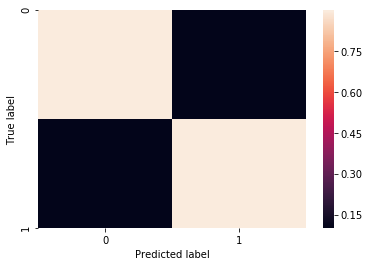

In [52]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets 
model.fit(X_train,y_train)

#Predict Output 
predicted= model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using NB is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
DECISION TREE REGRESSOR

The accuracy using DecisionTreeRegressor is: 89.84375


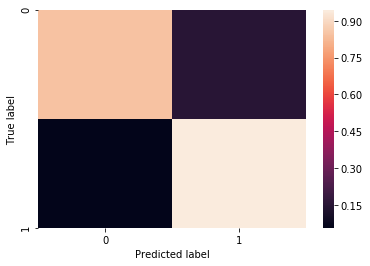

In [53]:
# Define model
DT_model = DecisionTreeRegressor()

# Fit model
DT_model.fit(X_train, y_train)

#Predict Output 
predicted= DT_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using DecisionTreeRegressor is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
SUPPORT VECTOR MACHINE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



The accuracy using SVC Classifier is: 92.96875


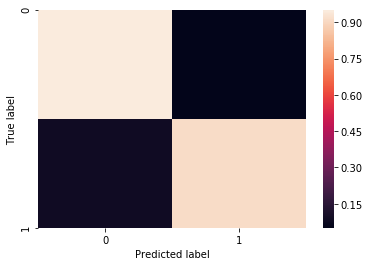

In [54]:
# Define model
SVC_model = svm.SVC()

# Fit model
SVC_model.fit(X_train, y_train)

#Predict Output 
predicted= SVC_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using SVC Classifier is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
RANDOM FOREST CLASSIFIER

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



The accuracy using RandomForest Classifier is: 90.625


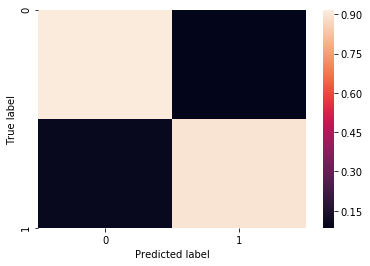

In [55]:
# Define model
RF_model = RandomForestClassifier(max_depth=2, random_state=0)

# Fit model
RF_model.fit(X_train, y_train)

#Predict Output 
predicted= RF_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using RandomForest Classifier is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [56]:
TTM=pd.read_csv('Testmatches.csv')
TTM["id"]=TTM["match_id"]
TTM = TTM.drop('match_id', 1)
TTM.index=TTM["id"]
TTD=pd.read_csv('TestDeliveries.csv')

T=False
test_df = df_feature(TTM,TTD,T)

test_df


,match_id,Team A,Team B,season,toss_winner,dl_applied,Team_A_Batting_Average,Team_A_Bowling_Average,Team_A_Total_Runs,Team_B_Batting_Average,Team_B_Bowling_Average,Team_B_Total_Runs,Team_A_overall,Team_B_overall,super_over
match_id,,,,,,,,,,,,,,,
501,501,Team2,Team9,2014,Team2,0,2.94,0.064286,178.0,2.09,-1.035714,153.0,1.502143,0.527143,0
502,502,Team7,Team8,2014,Team8,0,2.50,-0.435714,164.0,2.24,-0.371429,165.0,1.032143,0.934286,0
503,503,Team5,Team1,2014,Team5,0,2.42,-0.621429,160.0,2.53,-0.400000,161.0,0.899286,1.065000,0
504,504,Team10,Team6,2014,Team6,0,2.43,-0.978571,154.0,2.65,-0.385714,156.0,0.725714,1.132143,0
505,505,Team8,Team2,2014,Team2,0,2.18,-0.842857,156.0,2.45,0.192857,159.0,0.668571,1.321429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,632,Team7,Team5,2016,Team5,0,1.97,-0.378571,138.0,2.03,-0.085714,139.0,0.795714,0.972143,0
633,633,Team3,Team5,2016,Team5,0,2.15,-0.592857,158.0,2.27,0.021429,159.0,0.778571,1.145714,0
634,634,Team1,Team6,2016,Team6,0,2.39,-0.135714,162.0,2.04,-0.207143,140.0,1.127143,0.916429,0


In [57]:
sub=pd.read_csv('submission.csv')
sub.index=sub['match_id']

In [58]:
print("Predicting...")
sub['team_1_win_flag'] =model.predict(test_df[train_feature])
sub.team_1_win_flag.replace([0,1], [1, 0], inplace=True)
print("writing...")
sub.to_csv('sub1.csv', index = False)
test_df.to_csv('test.csv',index=False)
print("done...")
print(sub.info())

Predicting...
writing...
done...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 501 to 636
Data columns (total 2 columns):
match_id           136 non-null int64
team_1_win_flag    136 non-null int64
dtypes: int64(2)
memory usage: 3.2 KB
None


In [61]:
sub.head(10)

,match_id,team_1_win_flag
match_id,,
501,501,1
502,502,0
503,503,0
504,504,0
505,505,0
506,506,1
507,507,0
508,508,1
509,509,1


test_df.head()